# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We have seen the power of transfer learning feature extraction and fin-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

OUr goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we are using a GPU
!nvidia-smi

Tue Oct 19 06:11:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function

In previous notebooks we have created a seris of helper function, let's download that

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-19 06:11:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-19 06:11:19 (57.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import  create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes working with less data

our goal is to beat original Food101 paper with 10% of the original training data, so let's download it.

The data we are downloading comes from the original Food101 dataset but has been preprocessed using the image_data_mode


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

--2021-10-19 06:11:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.128, 173.194.193.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   180MB/s    in 9.0s    

2021-10-19 06:11:32 (171 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/crab_cakes'.
There are 0 directories and 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # dont' shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model.
* Build a headless (no topless layers) functional EfficientNetB0 backboned-model (we will create our own output layer)

In [ ]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incroporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [ ]:
# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.) # Rescale inputs of images to between 0 and 1, required for models like REsNet50
], name='data_augmentation')

In [ ]:
# Setup the base model and freeze its layeer (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model architecture with trainable top leyers
inputs = layers.Input(shape=(224, 224, 3), name='input_layers')
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # This will put the base model in infrence mode so weights which need to be forzen, stays frozen.
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax',name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of the model we createed
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layers (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compile
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 156s 509ms/step - loss: 3.4957 - accuracy: 0.2451 - val_loss: 2.6658 - val_accuracy: 0.4174
Epoch 2/5
237/237 [==============================] - 97s 406ms/step - loss: 2.3626 - accuracy: 0.4549 - val_loss: 2.2138 - val_accuracy: 0.4751
Epoch 3/5
237/237 [==============================] - 89s 373ms/step - loss: 1.9853 - accuracy: 0.5230 - val_loss: 2.0662 - val_accuracy: 0.4934


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f3d401ec200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 4/5
237/237 [==============================] - 81s 341ms/step - loss: 1.7692 - accuracy: 0.5624 - val_loss: 1.9773 - val_accuracy: 0.5003
Epoch 5/5
237/237 [==============================] - 76s 319ms/step - loss: 1.6096 - accuracy: 0.5980 - val_loss: 1.9225 - val_accuracy: 0.5066


In [ ]:
# Evaluate on the whole dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

 48/790 [>.............................] - ETA: 1:39 - loss: 2.1747 - accuracy: 0.4447

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> **Question:** What do these curves seggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on training data and not on unseen data)

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (it's typeically best practice to lower the lr when fine-tuning)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
# What layers in model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model her already done 5 epochs, this is the total number of epochs we are after

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

In [ ]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

In [ ]:
# Compare the histories of feature extraction model and fine-tune model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and Loading our Model

To use our model in external application, we wil need to save it and export it somewhere.

In [ ]:
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Load and evaluted saved model
loaded_model = tf.keras.models.load_model('drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model')

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 134s 131ms/step - loss: 1.6223 - accuracy: 0.5783


[1.6223490238189697, 0.5783366560935974]

## Evaluating the perfromance of the big dog model across all differnet classes

Let's make some predictions, visualize them and then later find out which predicitions were teh most wrong.

In [ ]:
import tensorflow as tf

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-10-19 06:12:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 172.217.214.128, 172.253.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   157MB/s    in 0.3s    

2021-10-19 06:12:31 (157 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
# Load in saved model
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [ ]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 137s 135ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
# Make predictions with our model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 92s 114ms/step


In [ ]:
len(test_data)

790

In [ ]:
790 * 32

25280

In [ ]:
# How many predictions ar there?
len(preds_probs)

25250

In [ ]:
# What's the shape of our prediction
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, ..., 1.4138899e-09,
        8.3530460e-05, 3.0897565e-03],
       [9.6401680e-01, 1.3753089e-09, 8.4779976e-04, ..., 5.4286684e-05,
        7.8363253e-12, 9.8467334e-10],
       [9.5925868e-01, 3.2534019e-05, 1.4867033e-03, ..., 7.1891884e-07,
        5.4398350e-07, 4.0276311e-05],
       ...,
       [4.7313324e-01, 1.2931301e-07, 1.4805583e-03, ..., 5.9749611e-04,
        6.6969820e-05, 2.3469329e-05],
       [4.4571780e-02, 4.7265351e-07, 1.2258515e-01, ..., 6.3498578e-06,
        7.5319103e-06, 3.6778715e-03],
       [7.2438985e-01, 1.9249777e-09, 5.2310857e-05, ..., 1.2291447e-03,
        1.5793171e-09, 9.6395503e-05]], dtype=float32)

In [ ]:
# What does the first prediction probability looks like
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9541941e-02, 3.5742332e-06, 4.1376889e-02, 1.0660903e-09,
        8.1613996e-09, 8.6639682e-09, 8.0926134e-07, 8.5652442e-07,
        1.9858850e-05, 8.0977554e-07, 3.1727692e-09, 9.8673388e-07,
        2.8532100e-04, 7.8049661e-10, 7.4230990e-04, 3.8915794e-05,
        6.4740016e-06, 2.4977169e-06, 3.7891397e-05, 2.0678806e-07,
        1.5538471e-05, 8.1506892e-07, 2.6230925e-06, 2.0010653e-07,
        8.3827712e-07, 5.4215743e-06, 3.7391112e-06, 1.3150788e-08,
        2.7761345e-03, 2.8051816e-05, 6.8561651e-10, 2.5574524e-05,
        1.6688934e-04, 7.6409645e-10, 4.0452869e-04, 1.3150487e-08,
        1.7957433e-06, 1.4448400e-06, 2.3062853e-02, 8.2465459e-07,
        8.5366531e-07, 1.7138503e-06, 7.0526130e-06, 1.8402382e-08,
        2.8553984e-07, 7.9482870e-06, 2.0682012e-06, 1.8525193e-07,
        3.3619781e-08, 3.1522335e-04, 1.0410886e-05, 8.5448306e-07,
        8.4741890e-01, 1.0555387e-05, 4.4094719e-07, 3.7404192e-05,
        3.5306137e-05, 3.2489079e-05, 6.7313988e

Our model outputs a prediction probability array (with N number of vaiables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f'Number of prediction probabilities for sample 0: {len(preds_probs[0])}')
print(f'What prediction probability sample 0 looks like: {preds_probs[0]}')
print(f'The class with the hightes prediction probability by the model for sample 0: {preds_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like: [5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 1.0

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we have got prediction arrays of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, ....0, 0]

y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating mode's prediction
one way to check that our model's prediction array is in the same order as our test labels array is to find the accuarcy score.

In [ ]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [ ]:
## Let's get visual: making a confusion metrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

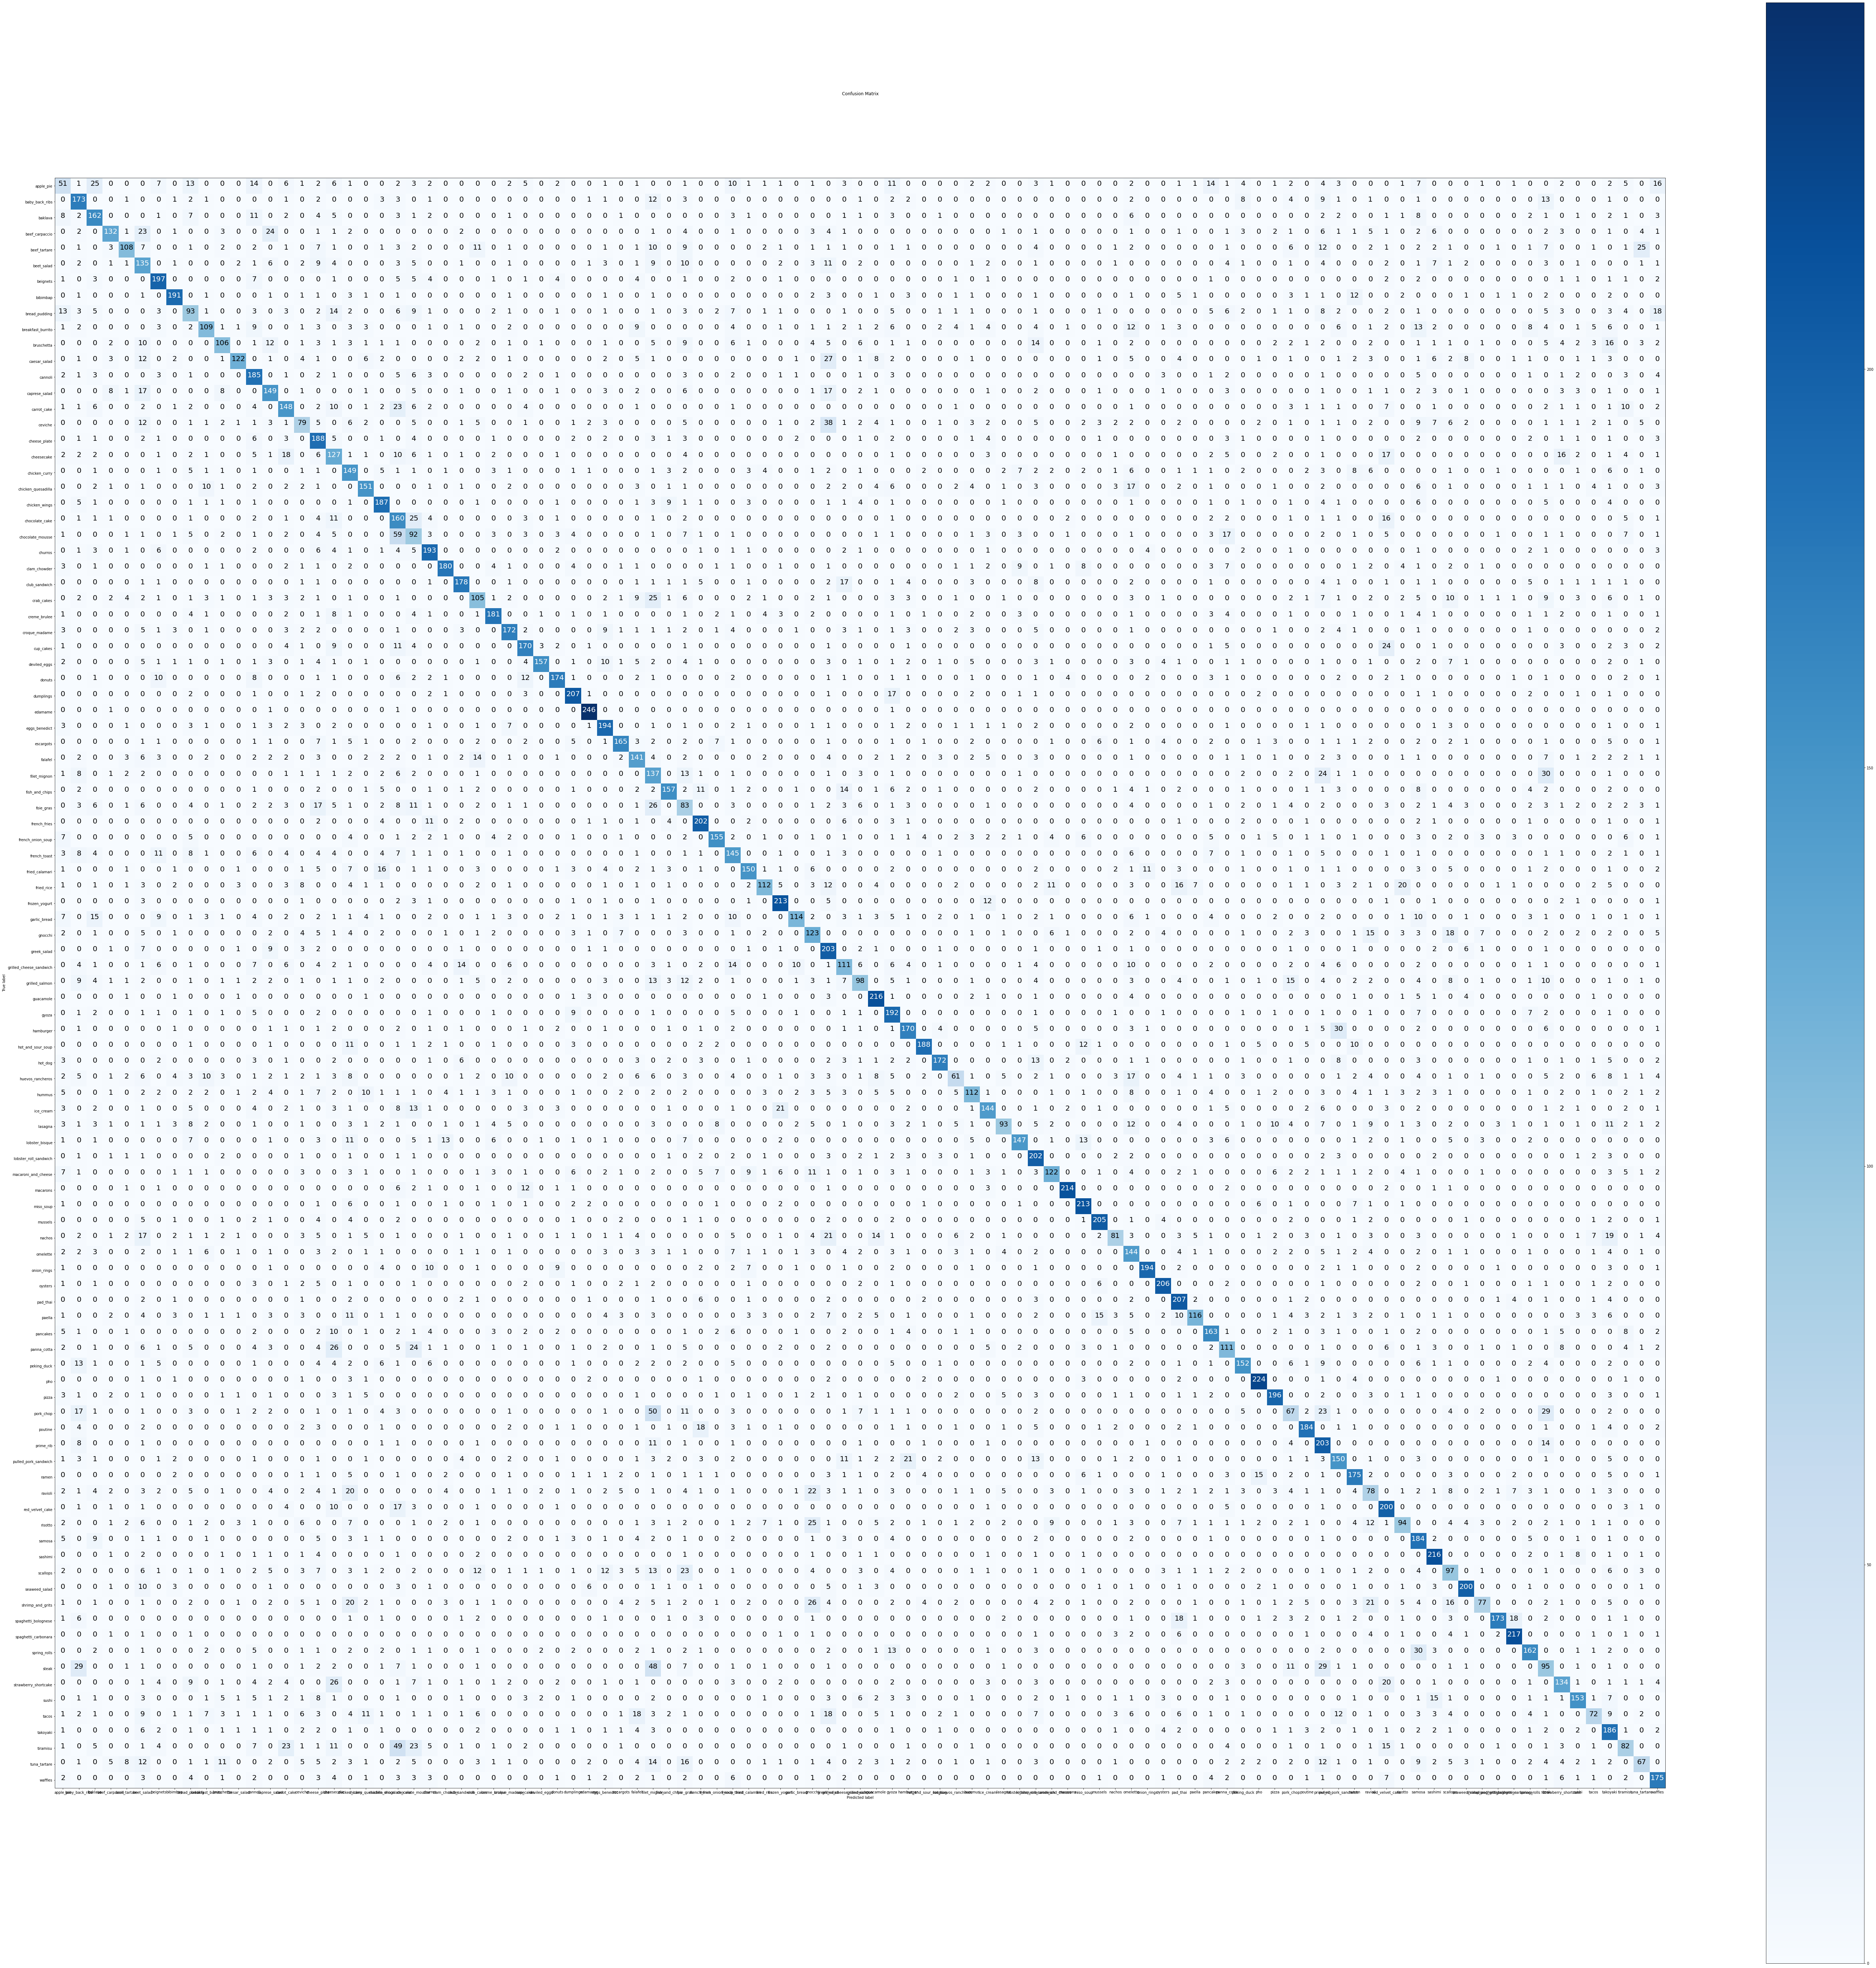

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

We need to make some changes in make_confusion_matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

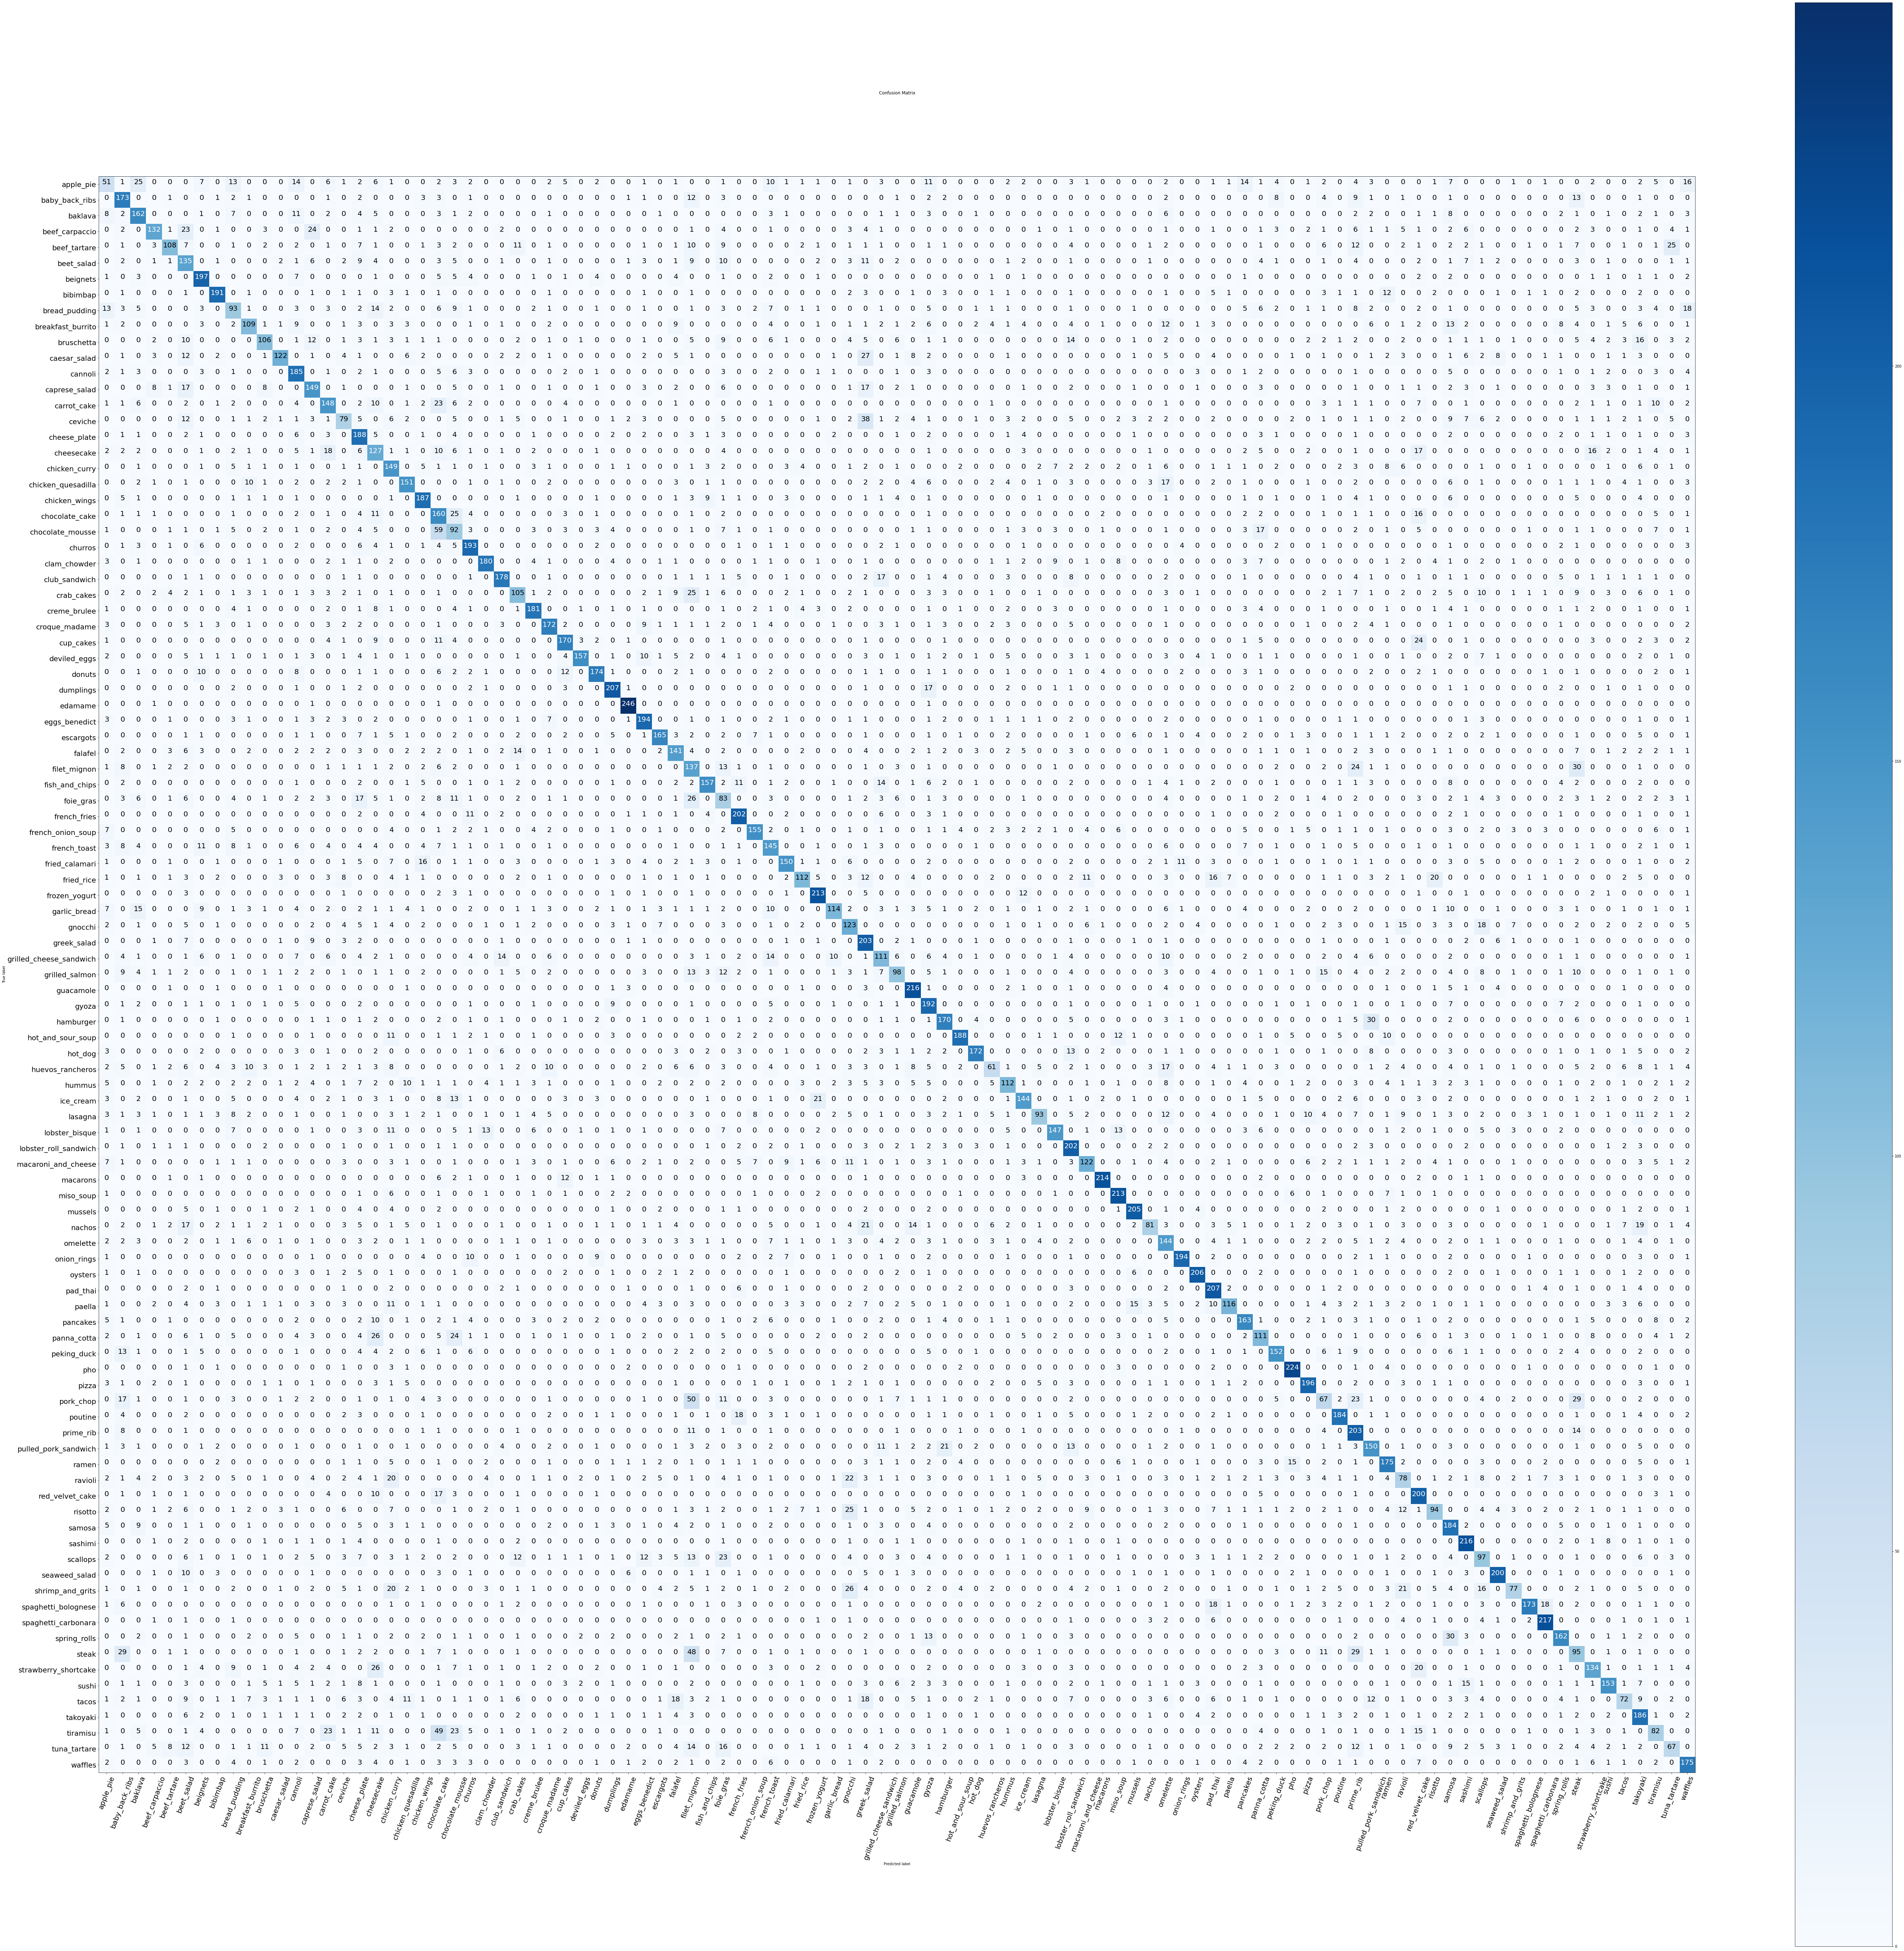

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation tran going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The number above give a great class-by-class evaluation of our model's prediction but with so many classes, they are quite hard to understand.

How about we create a visualization to get a better understanding?

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores..

In [ ]:
class_names[98]

'tiramisu'

In [ ]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == 'accuracy': # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores    

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

In [ ]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

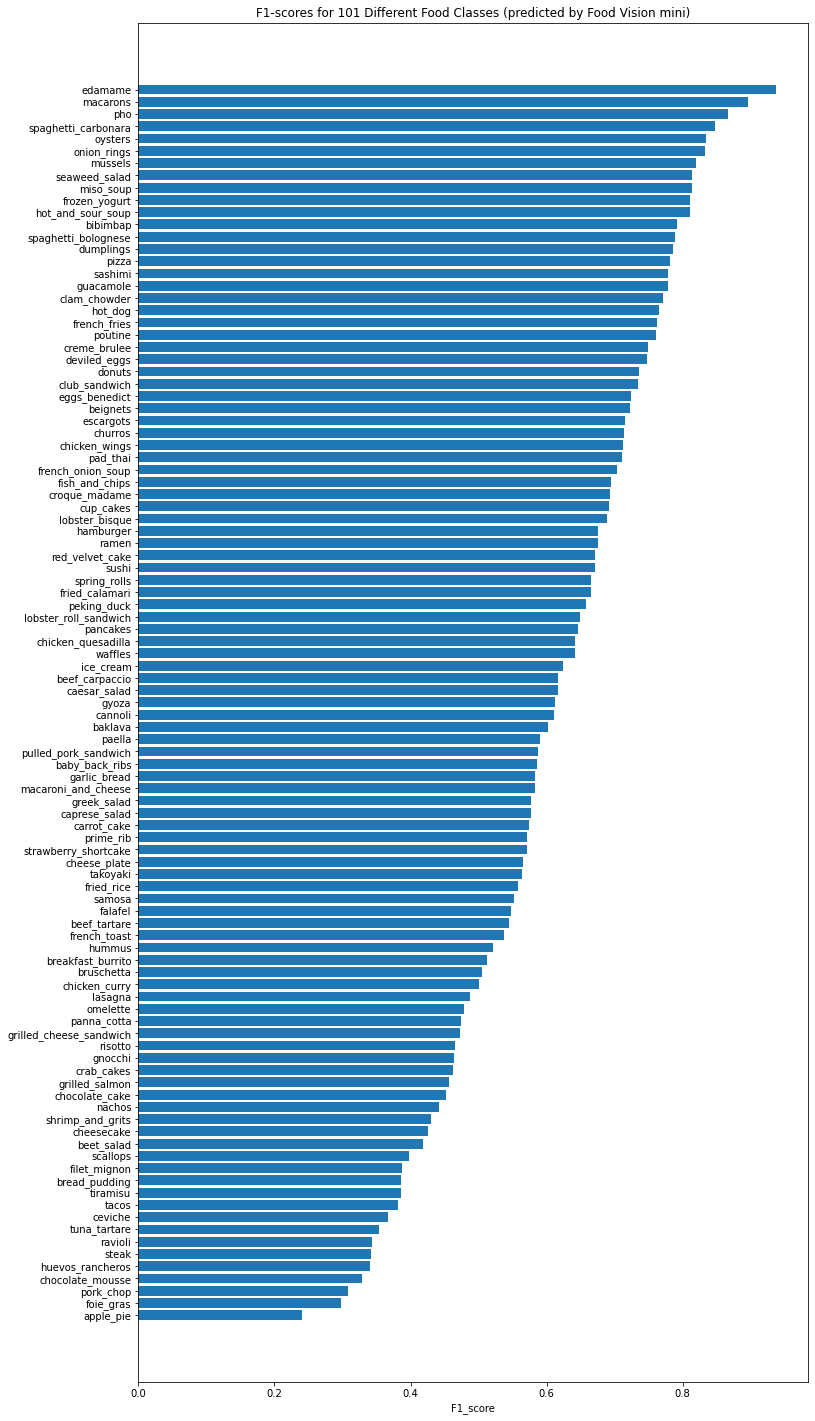

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values) # get f1-scores values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1_score')
ax.set_title('F1-scores for 101 Different Food Classes (predicted by Food Vision mini)')
ax.invert_yaxis(); # reverse the order of our plot

# Challenge: add values to end of each bar of what the actual f1-score is

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the imge
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow 

Now we have got a function to load and prepare target images, their target label and our model's predictions.

In [ ]:
test_dir = test_dir + '/'

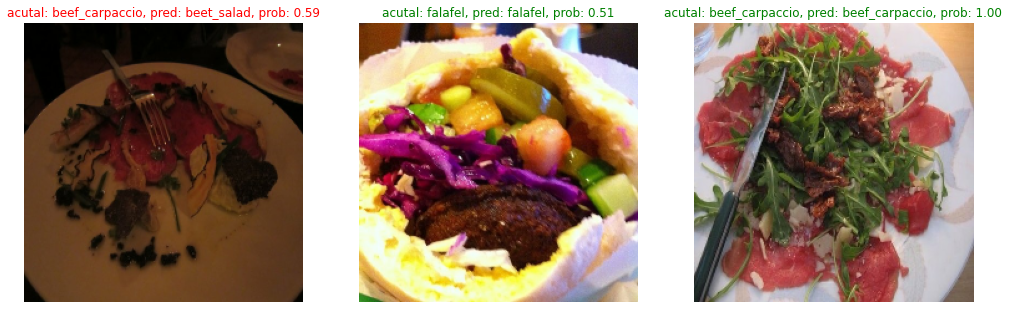

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a certain class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name)) 
  filepath = test_dir + class_name + '/' + filename
  

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probability array
  pred_class = class_names[pred_prob.argmax()]
  # print(pred_prob)
  # print(pred_class)

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r' 

  plt.title(f'acutal: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}', c=title_color)
  plt.axis(False)

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth lables, predicted classes (form our model), max prediction probabilities.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the predictions)
4. Sort the DataFrame based on wrong predictions
5. Visualize the images with the highest prediction probabilities but have wrong prediction.

In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': pred_classes,
                        'pred_conf': preds_probs.max(axis=1), # get the maximum predicition prbability value,]
                        'y_true_classname': [class_names[i] for i in y_labels],
                        'y_pred_classname': [class_names[i] for i in pred_classes]})

pred_df

img_path  ...      y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4      b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...          cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...  strawberry_shortcake
25249  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...         False
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
...                                                  ...  ...           ...
8763   b'/content/101_food_classes_10_percent/test/es...  ...         False
2663   b'/content/101_food_classes_10_percent/test/br...  ...         False
7924   b'/content/101_food_classes_10_percent/test/do...  ...         False
18586  b'/content/101_food_classes_10_percent/test/pe...  ...         False
3519   b'/content/101_food_classes_10_percent/test/ca...  ...         False

[100 rows x 7 columns]

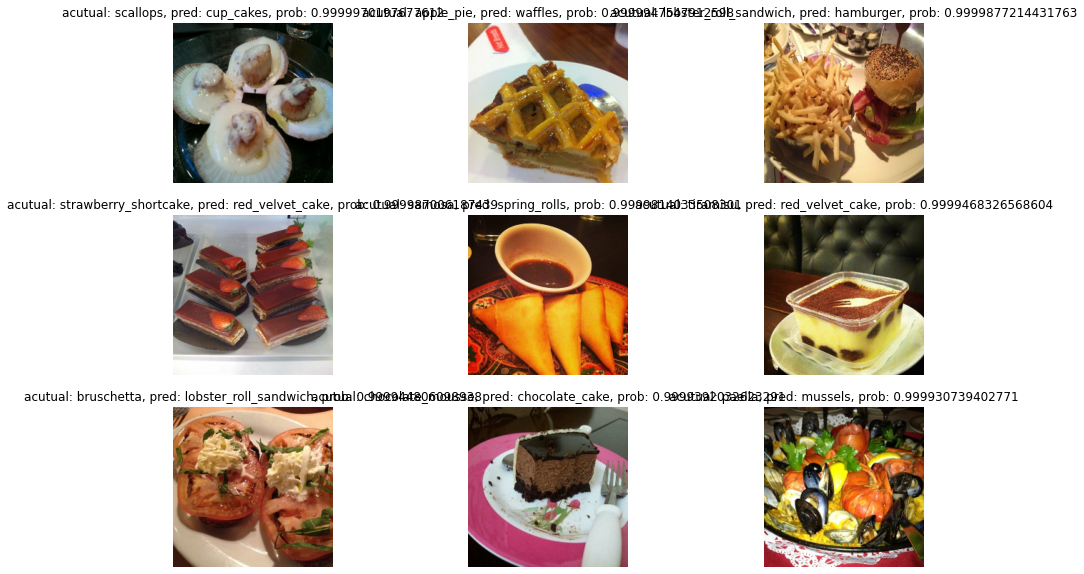

In [ ]:
# 5. Visualize the test data samples which have the wrong data prediction but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index: start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f'acutual: {y_true_classname}, pred: {y_pred_classname}, prob: {pred_prob}')
  plt.axis(False)

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data('custom_food_images.zip')

--2021-10-19 07:27:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 173.194.196.128, 173.194.198.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.09s   

2021-10-19 07:27:50 (135 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom food images filepaths
custom_food_images = ['custom_food_images/' + img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg']

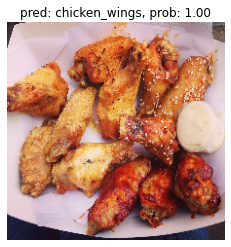

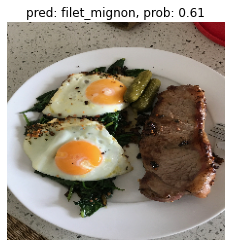

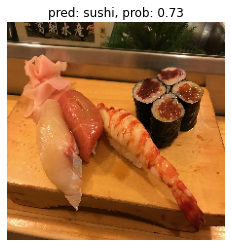

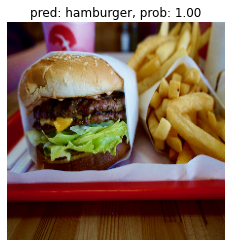

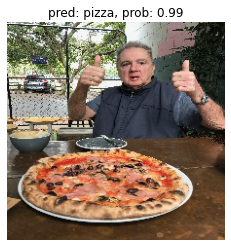

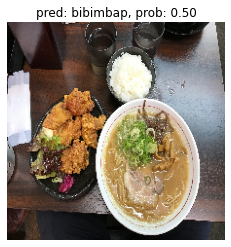

In [ ]:
# Make predictions and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as our model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highest prediction value

  # Plot the appropiate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f'pred: {pred_class}, prob: {pred_prob.max():.2f}')
  plt.axis(False)